In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg

# Bubble Graphs

### Data Cleaning Functions

In [104]:
def find_columns_with_star(dataframe):
    # Use the any() method to check for columns containing the value '*'
    columns_with_star = dataframe.columns[dataframe.eq('*').any()]
    return columns_with_star

In [105]:
def remove_rows_with_star(dataframe):
    # Use boolean indexing to filter rows without the value '*'
    dataframe_no_star = dataframe[~dataframe.apply(lambda row: row.eq('*')).any(axis=1)]

    return dataframe_no_star

In [106]:
def find_null_rows(dataframe, column_name):
    # Use boolean indexing to filter rows with null values in the specified column
    null_rows = dataframe[dataframe[column_name].isnull()]

    # Get the values of the null rows in the specified column
    null_values = null_rows[column_name]

    # Combine the null_rows DataFrame and the null_values Series to get the result
    result = pd.concat([null_rows, null_values.rename('Null Values')], axis=1)

    return result

In [107]:
# Replace the NaN value in 'Total Approved Policies' with a median value
def replace_nan_with_median(dataframe, column_name):
    # Calculate the median value of the column excluding NaN values
    median_value = dataframe[column_name].median(skipna=True)

    # Use fillna() to replace NaN values with the calculated median value
    dataframe[column_name].fillna(median_value, inplace=True)

    return dataframe

In [108]:
def remove_percent_sign(dataframe, column_name):
    # Use str.replace() to remove the '%' sign and then convert the values to float
    dataframe[column_name] = dataframe[column_name].str.replace('%', '').astype(float)

    return dataframe

In [109]:

def convert_string_to_float(dataframe, column_name):
    # Use to_numeric() to convert non-null string values to float, and skip null (NaN) values
    dataframe[column_name] = pd.to_numeric(dataframe[column_name], errors='coerce')

    return dataframe

In [110]:
def replace_value_in_column(df, column_name, old_value, new_value):
    df[column_name] = df[column_name].replace(old_value, new_value)
    return df

In [111]:
def convert_to_float(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].astype(float)
    return dataframe

In [112]:
def convert_to_int(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].astype(int)
    return dataframe

In [113]:
def county_data_cleaning(county_data):
    county_data.dropna(subset=['District Type'], inplace=True)
    county_data_copy = county_data.copy()
    county_data_copy = county_data_copy[[
        'District Type', 
        'District Name', 
       'Student Enrollment \n(2021-22)',
       '% Unduplicated \n(2021-22)', 
       'Average \nPollution Burden Percentile',
       'District-Wide Sustainability Initiatives\n1 (Yes) 0 (No)',
       'District-Wide Sustainability Staff\n1 (Yes) 0 (No)']]
    county_data_copy = remove_rows_with_star(county_data_copy)
    county_data_copy = county_data_copy.replace(r'[$,]', '', regex=True)
    county_data_copy = remove_percent_sign(county_data_copy, '% Unduplicated \n(2021-22)')
    county_data_copy = convert_to_int(county_data_copy, 'Student Enrollment \n(2021-22)')
    county_data_copy = convert_to_float(county_data_copy, 'Average \nPollution Burden Percentile')
    county_data_copy = convert_to_int(county_data_copy, 'District-Wide Sustainability Initiatives\n1 (Yes) 0 (No)')
    county_data_copy['District with investment'] = np.where((county_data_copy['District-Wide Sustainability Initiatives\n1 (Yes) 0 (No)'] == 1) | (county_data_copy['District-Wide Sustainability Staff\n1 (Yes) 0 (No)'] == 1), 1, 0)
    county_data_copy = county_data_copy [['District Type', 'District Name', '% Unduplicated \n(2021-22)', 'Student Enrollment \n(2021-22)', 'Average \nPollution Burden Percentile',"" 'District with investment']]
    county_data_copy.index = np.arange(1, len(county_data_copy)+1)
    return county_data_copy

In [114]:
def pollution_vs_unduplicated_graph(cleaned_county_data, county_name):
    '''
    cleaned_county_data is a county dataset cleaned by using function county_data_cleaning(county_data)
    county_name is a string, e.g., 'San Mateo County'
    '''
    x_values = cleaned_county_data['Average \nPollution Burden Percentile']
    y_values = cleaned_county_data['% Unduplicated \n(2021-22)']
    dot_sizes = cleaned_county_data['Student Enrollment \n(2021-22)']
    scaling_factor = 0.7
    dot_sizes_scaled = dot_sizes * scaling_factor

    plt.rcParams['font.family'] = 'DejaVu Sans'

    # Create the scatter plot
    plt.figure(figsize=(20, 18))
    
    # Define the boundaries of the upper-right quadrant
    x_upper_bound = max(x_values)
    y_upper_bound = max(y_values)

    # Add shaded background for the upper-right quadrant
    plt.axhspan(y_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    plt.axvspan(x_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    
    # # Scatter plot with original colors
    colors = {0: 'lightgreen', 1: 'darkgreen'}
    scatter = plt.scatter(x_values, y_values, s=dot_sizes_scaled,
                          c=[colors[i] for i in cleaned_county_data['District with investment']],
                          cmap='Greens', alpha=0.7)    
    
    # Label the dots with district numbers
    for i, (x, y) in enumerate(zip(x_values, y_values)):
        district_number = cleaned_county_data.index[i]  # Assuming index represents district numbers
        plt.text(x, y, district_number, ha='center', va='center', color='black', fontsize=25)

    # Set labels and title
    plt.xlabel('Average Pollution Burden Percentile', size=30)
    plt.xticks(range(0, 101, 10), size=20)
    plt.xlim(0, 100)
    plt.ylabel('% Unduplicated (2021-22)', size=30)
    plt.yticks(range(0, 101, 10), size=20)
    plt.ylim(0, 100)
    # plt.title(county_name + ': Pollution Burden Percentile vs. % Unduplicated', size=20, pad=30)

    # Add custom legend
    legend_labels = ['No District Investment in Staff or Initiatives', 'District Investment in Staff and/or Initiatives']  # Custom labels for the legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=25),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=25)]
    plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1.6, 1), loc='upper right', prop={"size": 25})

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Show the plot
    plt.savefig('Bubble Graphs Outputs/' + county_name + ' Bubble Visuals.png', bbox_inches='tight')
    plt.show()



In [115]:
def pollution_vs_unduplicated_graph_with_jitter(cleaned_county_data, county_name):
    '''
    cleaned_county_data is a county dataset cleaned by using function county_data_cleaning(county_data)
    county_name is a string, e.g., 'San Mateo County'
    '''
    x_values = cleaned_county_data['Average \nPollution Burden Percentile']
    y_values = cleaned_county_data['% Unduplicated \n(2021-22)']
    dot_sizes = cleaned_county_data['Student Enrollment \n(2021-22)']
    scaling_factor = 0.7
    dot_sizes_scaled = dot_sizes * scaling_factor

    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # Create the scatter plot
    plt.figure(figsize=(20, 18))
    
    # Define the boundaries of the upper-right quadrant
    x_upper_bound = max(x_values)
    y_upper_bound = max(y_values)

    # Add shaded background for the upper-right quadrant
    plt.axhspan(y_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    plt.axvspan(x_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    
    # Scatter plot with original colors
    colors = {0: 'lightgreen', 1: 'darkgreen'}
    
    # Add slight random jitter to the dot positions
    jitter_amount = 3.0  # Adjust as needed
    x_jitter = np.random.uniform(-jitter_amount, jitter_amount, len(x_values))
    y_jitter = np.random.uniform(-jitter_amount, jitter_amount, len(y_values))
    
    scatter = plt.scatter(x_values + x_jitter, y_values + y_jitter, s=dot_sizes_scaled,
                          c=[colors[i] for i in cleaned_county_data['District with investment']],
                          cmap='Greens', alpha=0.7)
    
    # Label the dots with district numbers
    for i, (x, y) in enumerate(zip(x_values, y_values)):
        district_number = cleaned_county_data.index[i]  # Assuming index represents district numbers
        plt.text(x + x_jitter[i], y + y_jitter[i], district_number, ha='center', va='center', color='black', fontsize=25)

    # Set labels and title
    plt.xlabel('Average Pollution Burden Percentile', size=30)
    plt.xticks(range(0, 101, 10), size=20)
    plt.xlim(0, 100)
    plt.ylabel('% Unduplicated (2021-22)', size=30)
    plt.yticks(range(0, 101, 10), size=20)
    plt.ylim(0, 100)
    
    # plt.title(county_name + ': Pollution Burden Percentile vs. % Unduplicated', size=20, pad=30)

    # Add custom legend
    legend_labels = ['No District Investment in Staff or Initiatives', 'District Investment in Staff and/or Initiatives']  # Custom labels for the legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=25),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=25)]
    plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1.6, 1), loc='upper right', prop={"size": 25})

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Show the plot
    plt.savefig('Bubble Graphs Outputs/' + county_name + ' Bubble Visuals.png', bbox_inches='tight')
    plt.show()

### San Diego

In [80]:
san_diego = pd.read_csv('Master County Tracker Database for CA District Data - San Diego.csv')

In [81]:
cleaned_san_diego = county_data_cleaning(san_diego)
cleaned_san_diego

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average \nPollution Burden Percentile,District with investment
1,Elementary School District,Alpine Union Elementary,33.85,1539,5.26,0
2,Unified School District,Bonsall Unified,39.63,2209,33.76,0
3,Unified School District,Borrego Springs Unified,11.26,2823,27.00,0
4,Elementary School District,Cajon Valley Union,61.58,16812,37.00,1
5,Elementary School District,Cardiff Elementary,16.32,631,50.00,1
6,Unified School District,Carlsbad Unified,22.60,11027,46.00,1
7,Elementary School District,Chula Vista Elementary,44.31,28878,43.00,1
8,Unified School District,Coronado Unified,12.38,2747,64.30,0
9,Elementary School District,Dehesa Elementary,0.50,9697,17.00,0
10,Elementary School District,Del Mar Union Elementary,19.64,3895,39.00,0


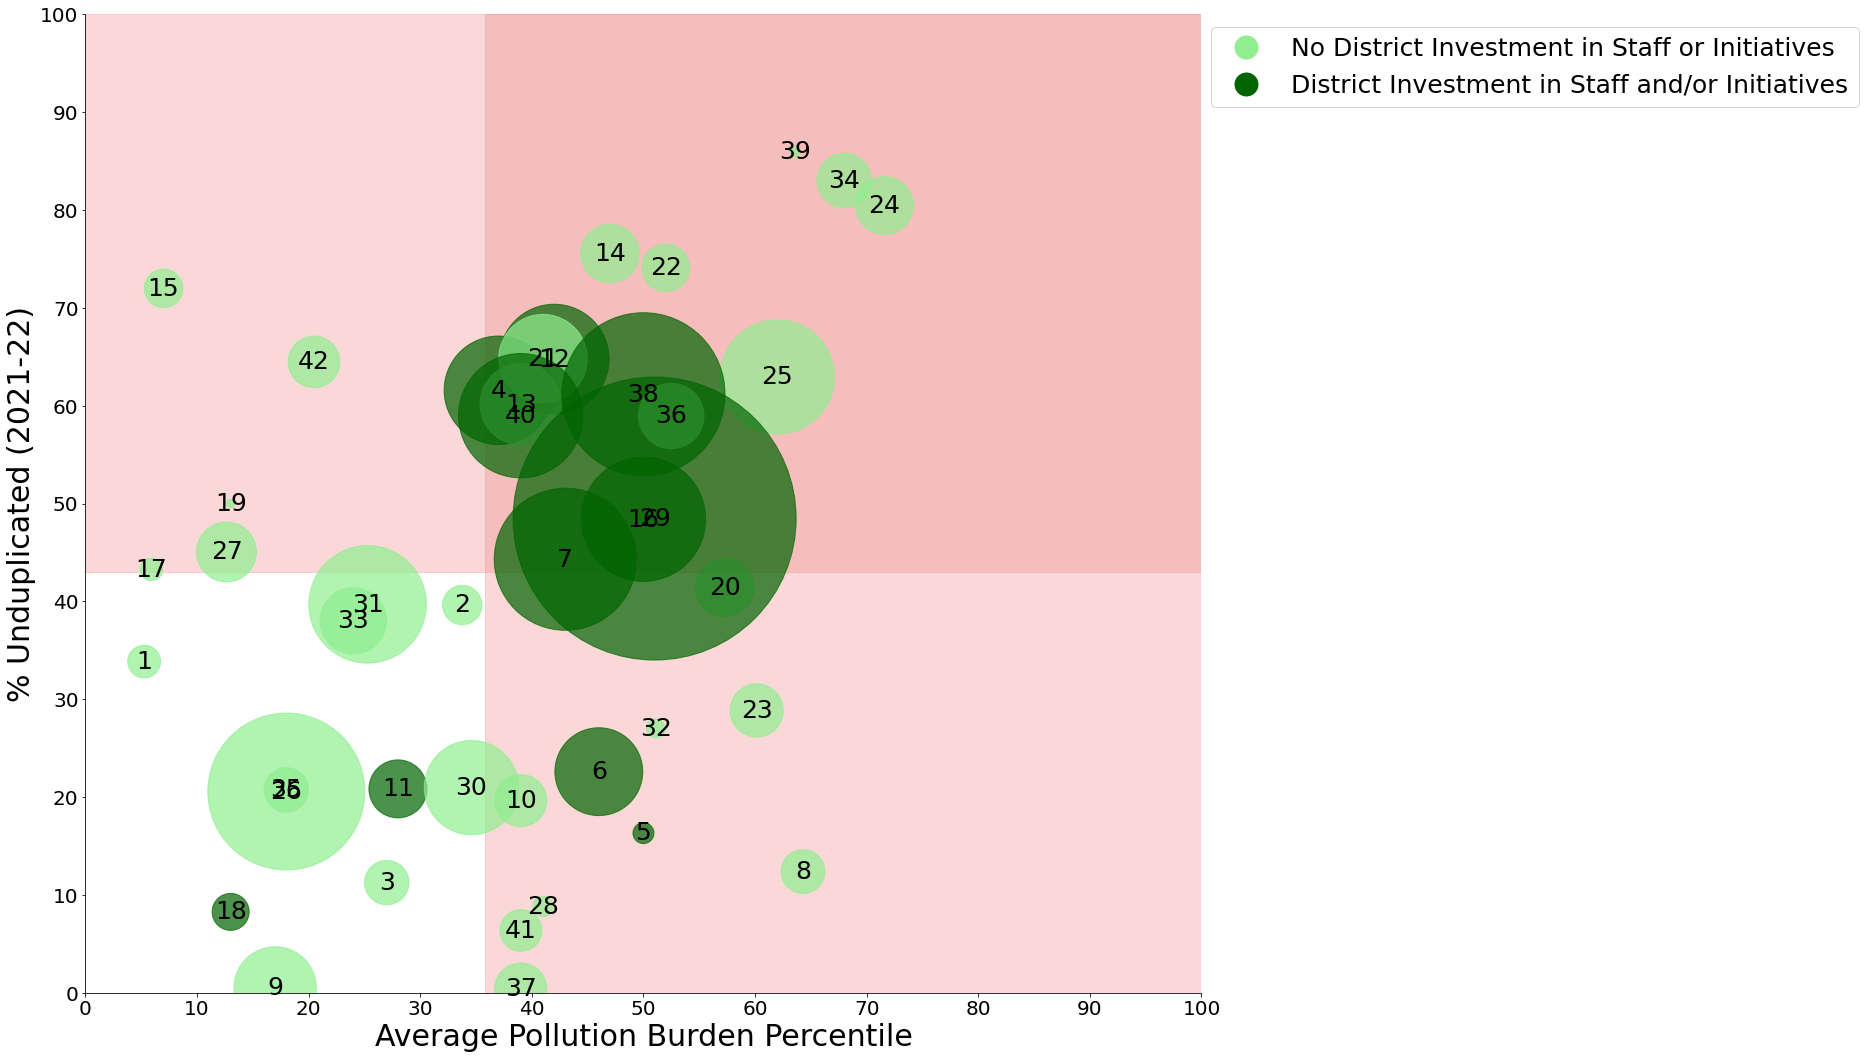

In [82]:
pollution_vs_unduplicated_graph(cleaned_san_diego, 'San Diego County')

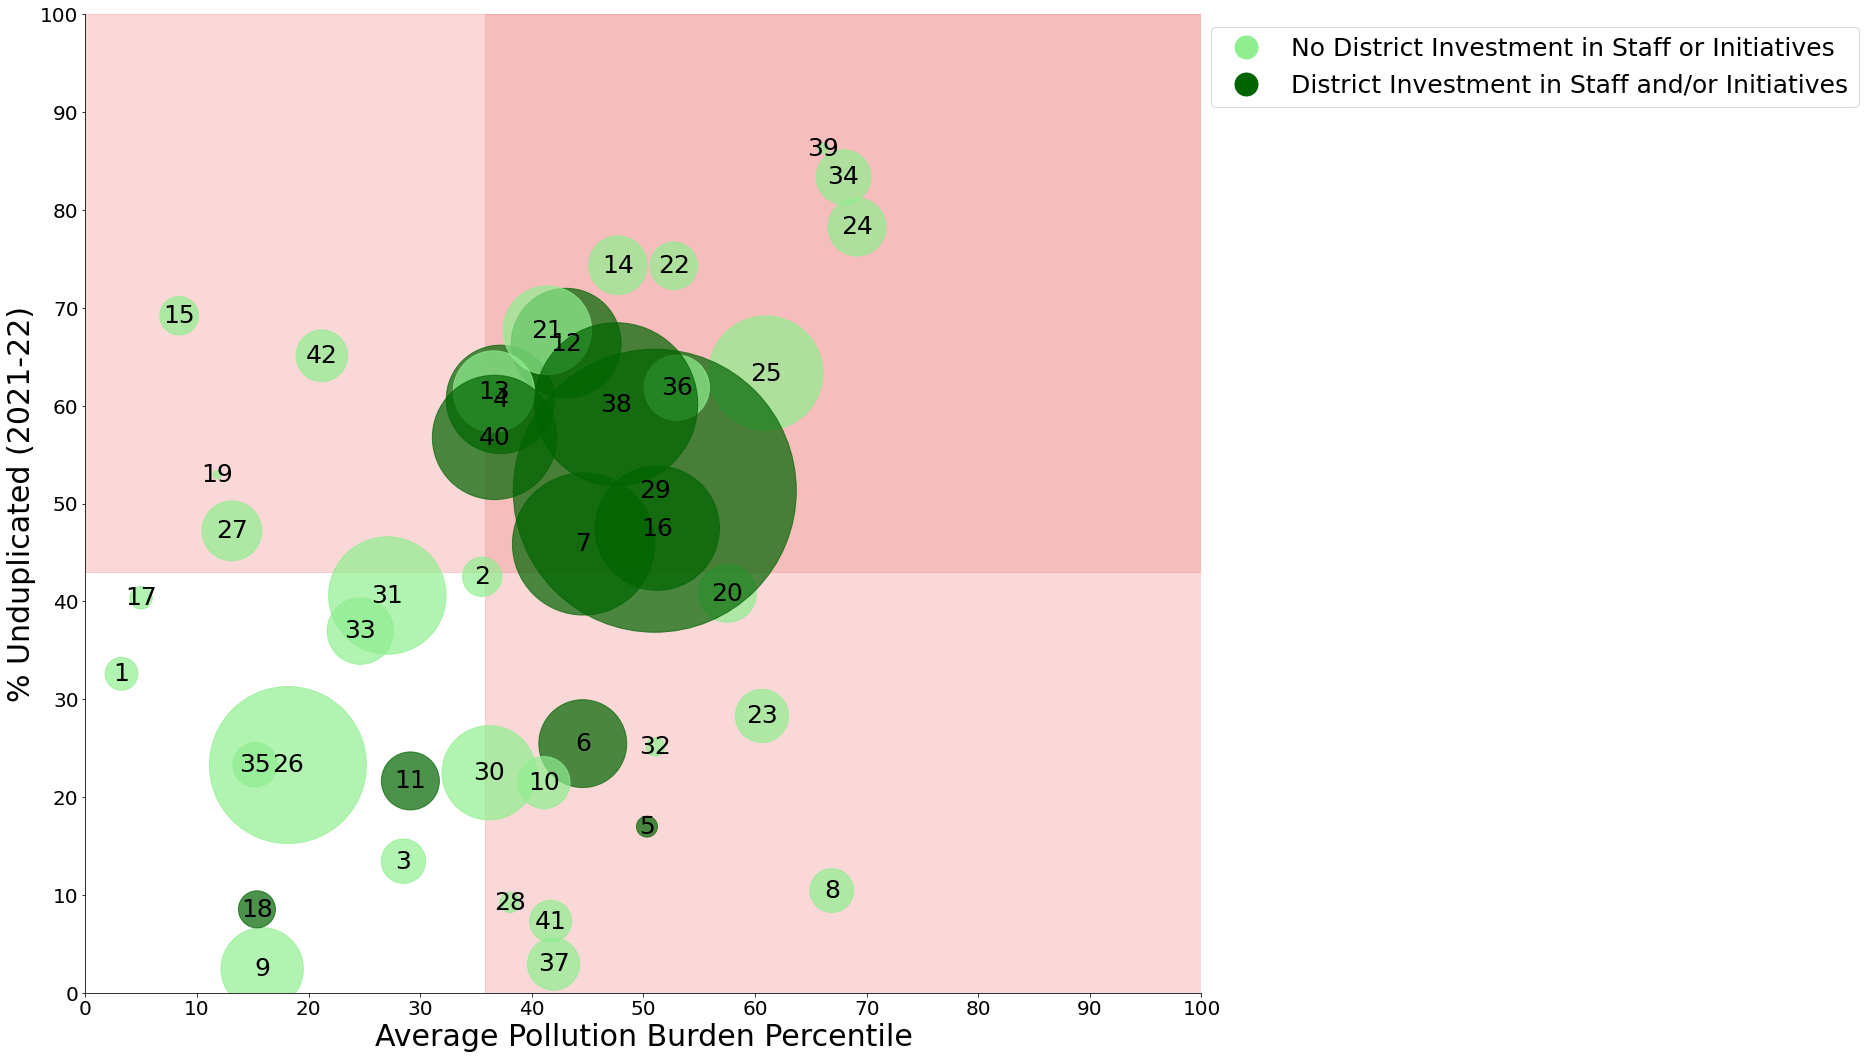

In [84]:
pollution_vs_unduplicated_graph_with_jitter(cleaned_san_diego, 'San Diego County')

### San Mateo

In [117]:
san_mateo = pd.read_csv('Master County Tracker Database for CA District Data - San Mateo (1).csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Master County Tracker Database for CA District Data - San Mateo (1).csv'

In [99]:
cleaned_san_mateo = county_data_cleaning(san_mateo)
cleaned_san_mateo

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average \nPollution Burden Percentile,District with investment
1,Elementary,Bayshore Elementary,66.29,350,70.3900,0
2,Elementary,Belmont-Redwood Shores Elementary,16.08,3967,8.9500,0
3,Elementary,Brisbane Elementary School District,27.33,450,63.2800,0
4,Elementary,Burlingame Elementary,22.89,3312,65.6900,1
5,Unified,Cabrillo Unified,43.73,2803,30.8100,1
6,Elementary,Hillsborough City Elementary,4.13,1260,14.2100,1
7,Elementary,Jefferson Elementary,52.70,6228,39.7600,1
8,High School District,Jefferson Union High,33.13,4452,27.4900,1
9,Unified,La Honda-Pescadero Unified,57.41,270,53.0400,1
10,Elementary,Las Lomitas Elementary,12.32,1088,58.5800,0


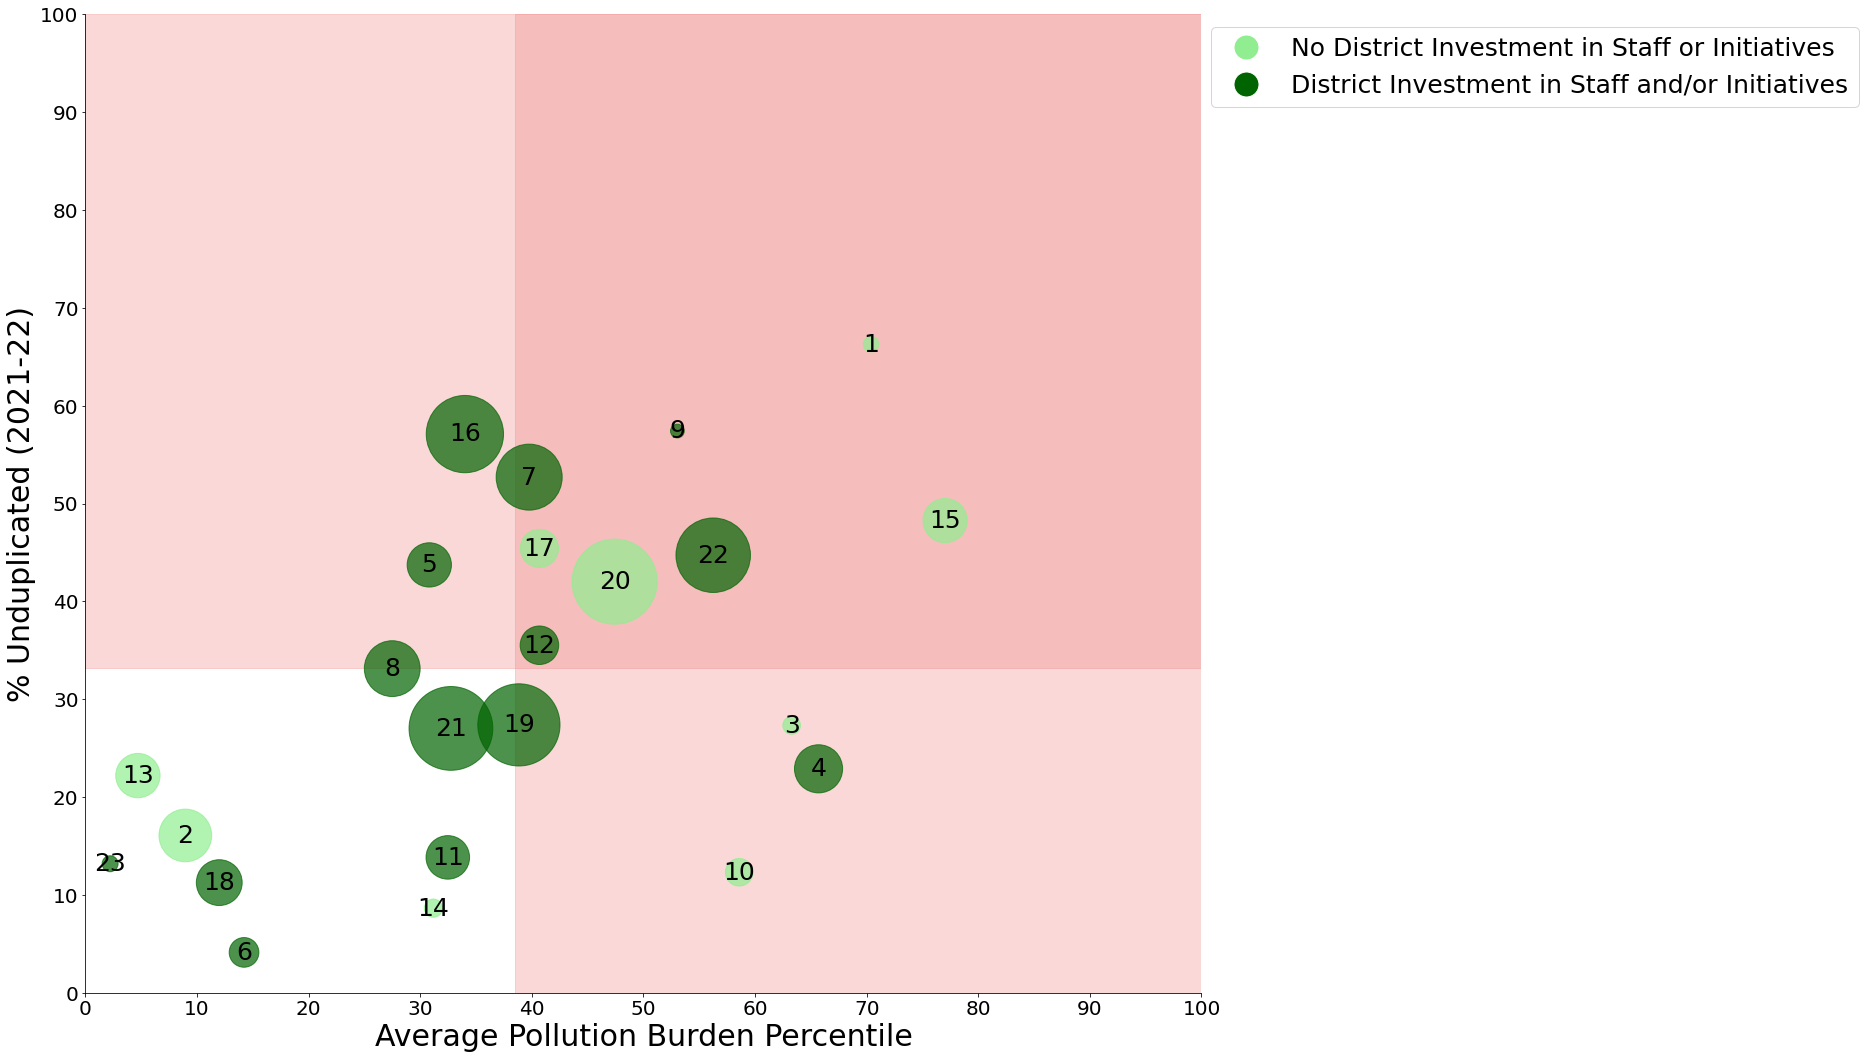

In [102]:
pollution_vs_unduplicated_graph(cleaned_san_mateo, 'San Mateo County')

### San Francisco

In [281]:
cleaned_san_francisco = county_data_cleaning(san_francisco)
cleaned_san_francisco

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average Cal EnviroScreen Percentile,District with investment
1,Unified School District,San Francisco Unified,52.22,55592,37.82,1


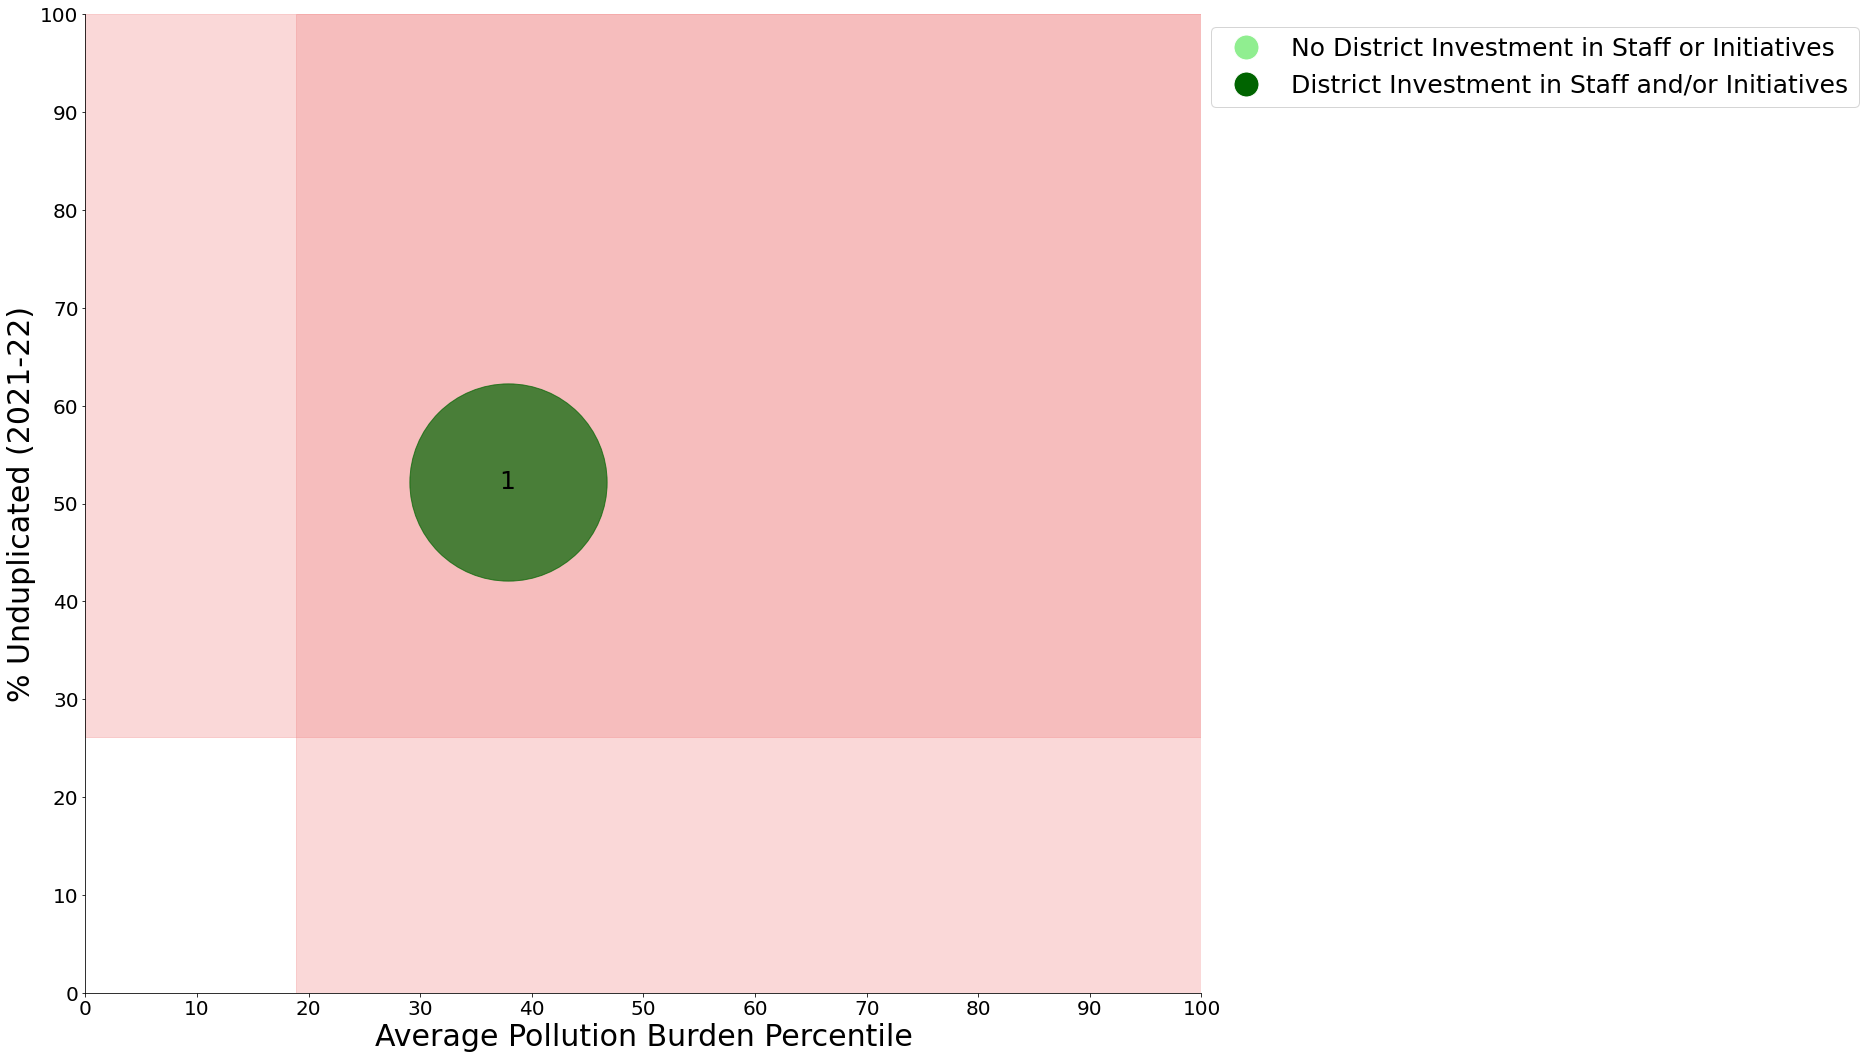

In [282]:
pollution_vs_unduplicated_graph(cleaned_san_francisco, 'San Francisco County')

### Solano

In [283]:
cleaned_solano = county_data_cleaning(solano)
cleaned_solano

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average Cal EnviroScreen Percentile,District with investment
1,Unified School District,Benicia Unified,25.50,4364,30.07,0
2,Unified School District,Dixon Unified,48.34,3439,73.43,0
3,Unified School District,Fairfield-Suisun Unified,53.68,20715,27.31,1
4,Unified School District,Travis Unified,43.37,5266,37.27,1
5,Unified School District,Vacaville Unified,37.07,13074,11.90,1
6,Unified School District,Vallejo City Unified,64.41,12717,44.83,1


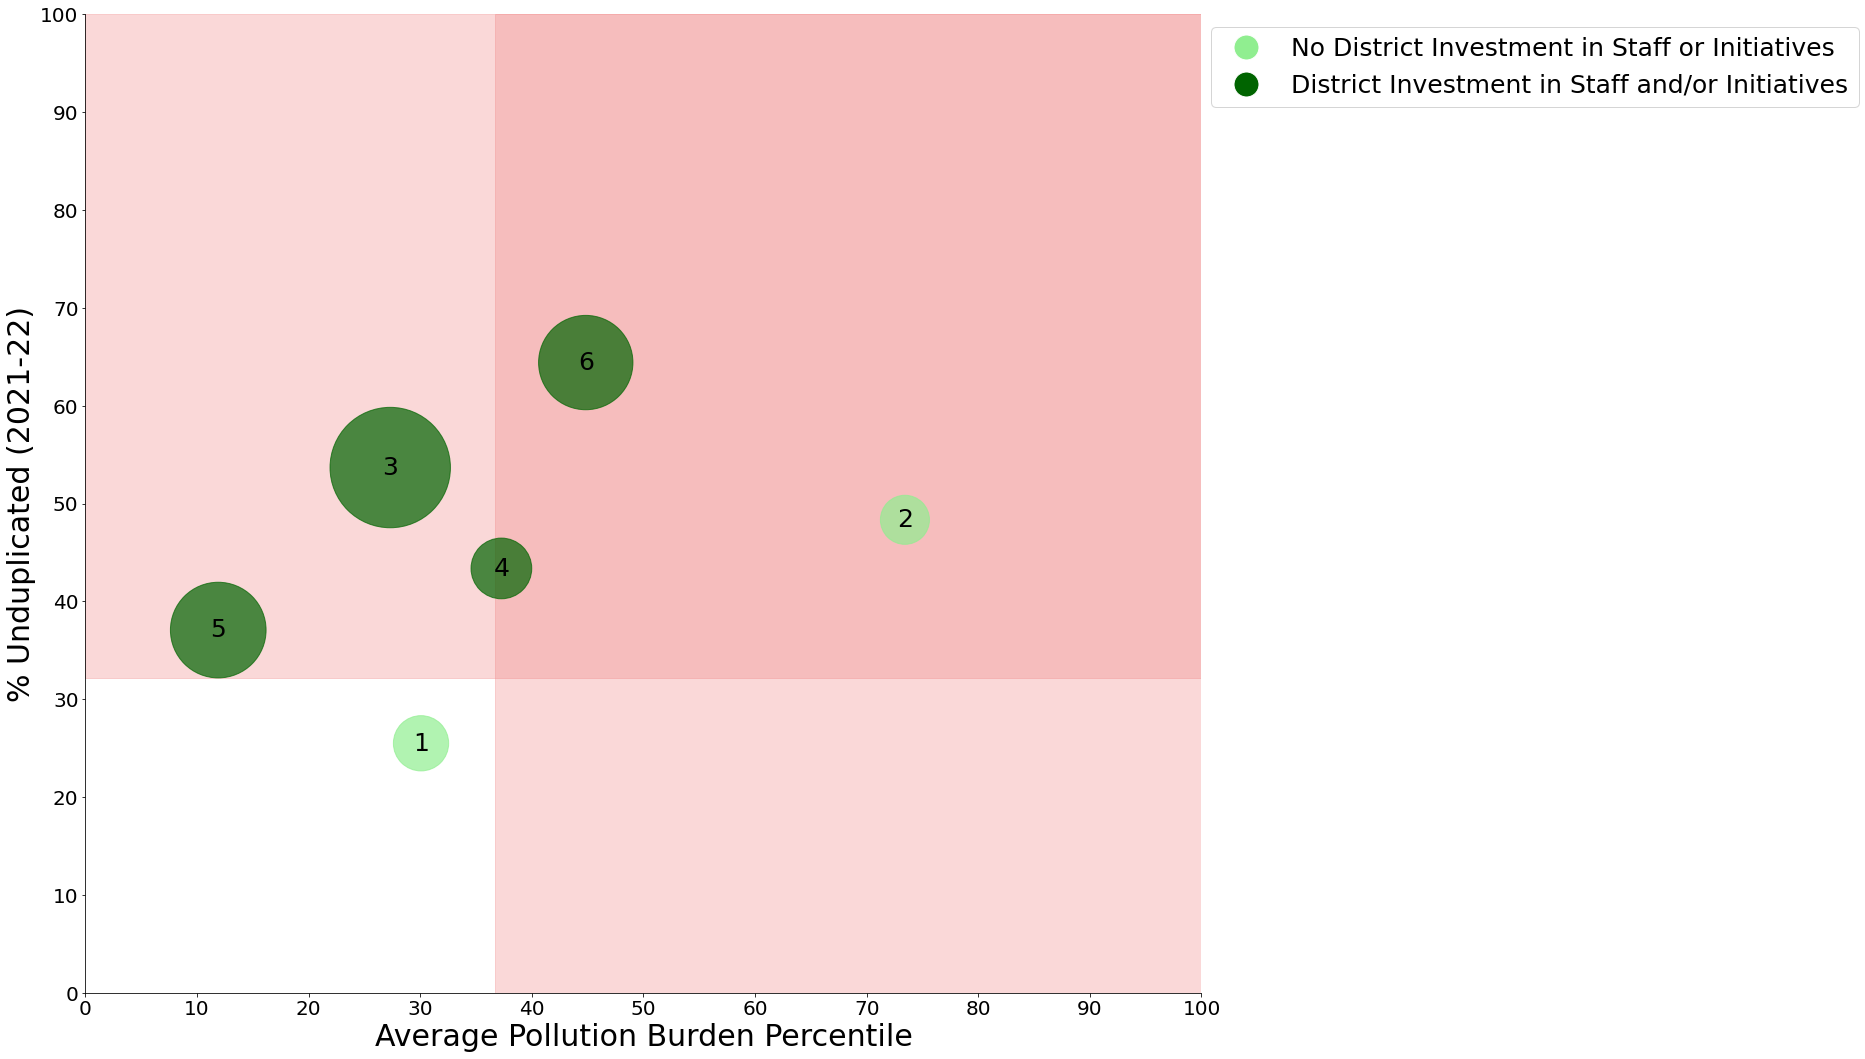

In [284]:
pollution_vs_unduplicated_graph(cleaned_solano, 'Solano County')

### Santa Cruz

In [285]:
cleaned_santa_cruz = county_data_cleaning(santa_cruz)
cleaned_santa_cruz

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average Cal EnviroScreen Percentile,District with investment
1,Elementary School District,Bonny Doon Union Elementary,16.24,117,30.26,0
2,Elementary School District,Happy Valley Elementary,12.84,109,38.28,1
3,Elementary School District,Live Oak Elementary,60.31,1728,31.55,0
4,Elementary School District,Mountain Elementary,19.72,142,6.46,0
5,Elementary School District,Pacific Elementary,40.69,145,30.26,1
6,Unified School District,Pajaro Valley Unified,72.67,18675,60.06,0
7,Unified School District,San Lorenzo Valley Unified,9.59,5534,30.44,0
8,Elementary School District,Santa Cruz City Elementary,42.27,1713,21.77,0
9,High School District,Santa Cruz City High,31.81,4584,44.19,0
10,Unified School District,Scotts Valley Unified,10.15,2660,52.58,0


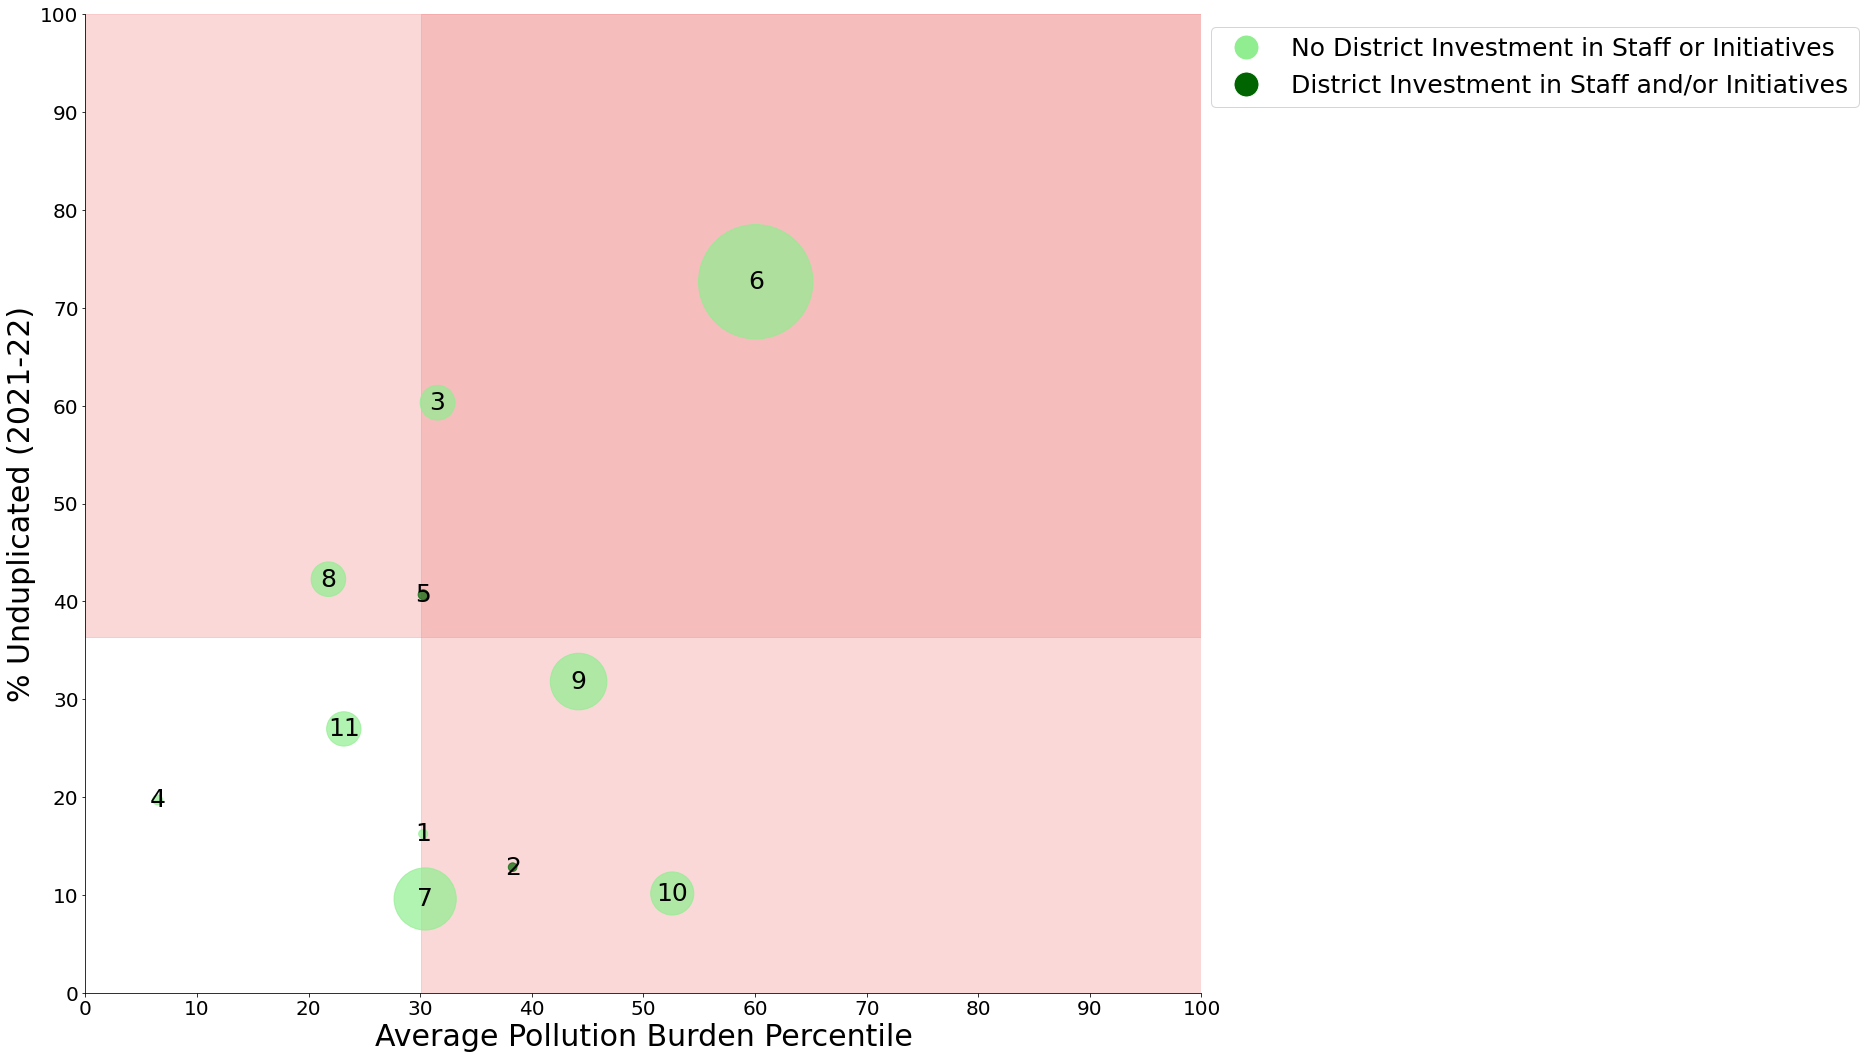

In [286]:
pollution_vs_unduplicated_graph(cleaned_santa_cruz, 'Santa Cruz County')

### San Joaquin

In [287]:
cleaned_san_joaquin = county_data_cleaning(san_joaquin)
cleaned_san_joaquin

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average Cal EnviroScreen Percentile,District with investment
1,Unified School District,Stockton Unified,72.41,39803,81.00,1
2,Unified School District,Lodi Unified,63.40,30727,54.15,1
3,Unified School District,Manteca Unified,61.74,24154,79.06,1
4,Unified School District,Tracy Joint Unified,52.24,15398,48.34,0
5,Unified School District,Lincoln Unified,57.54,8967,65.22,1
6,Unified School District,Lammersville Joint Unified,21.48,6980,90.87,0
7,Elementary School District,New Jerusalem Elementary,0.23,6670,83.39,0
8,Unified School District,Ripon Unified,23.07,4980,86.99,0
9,Unified School District,Escalon Unified,44.97,2906,85.33,0
10,Unified School District,Linden Unified,56.99,2339,73.52,0


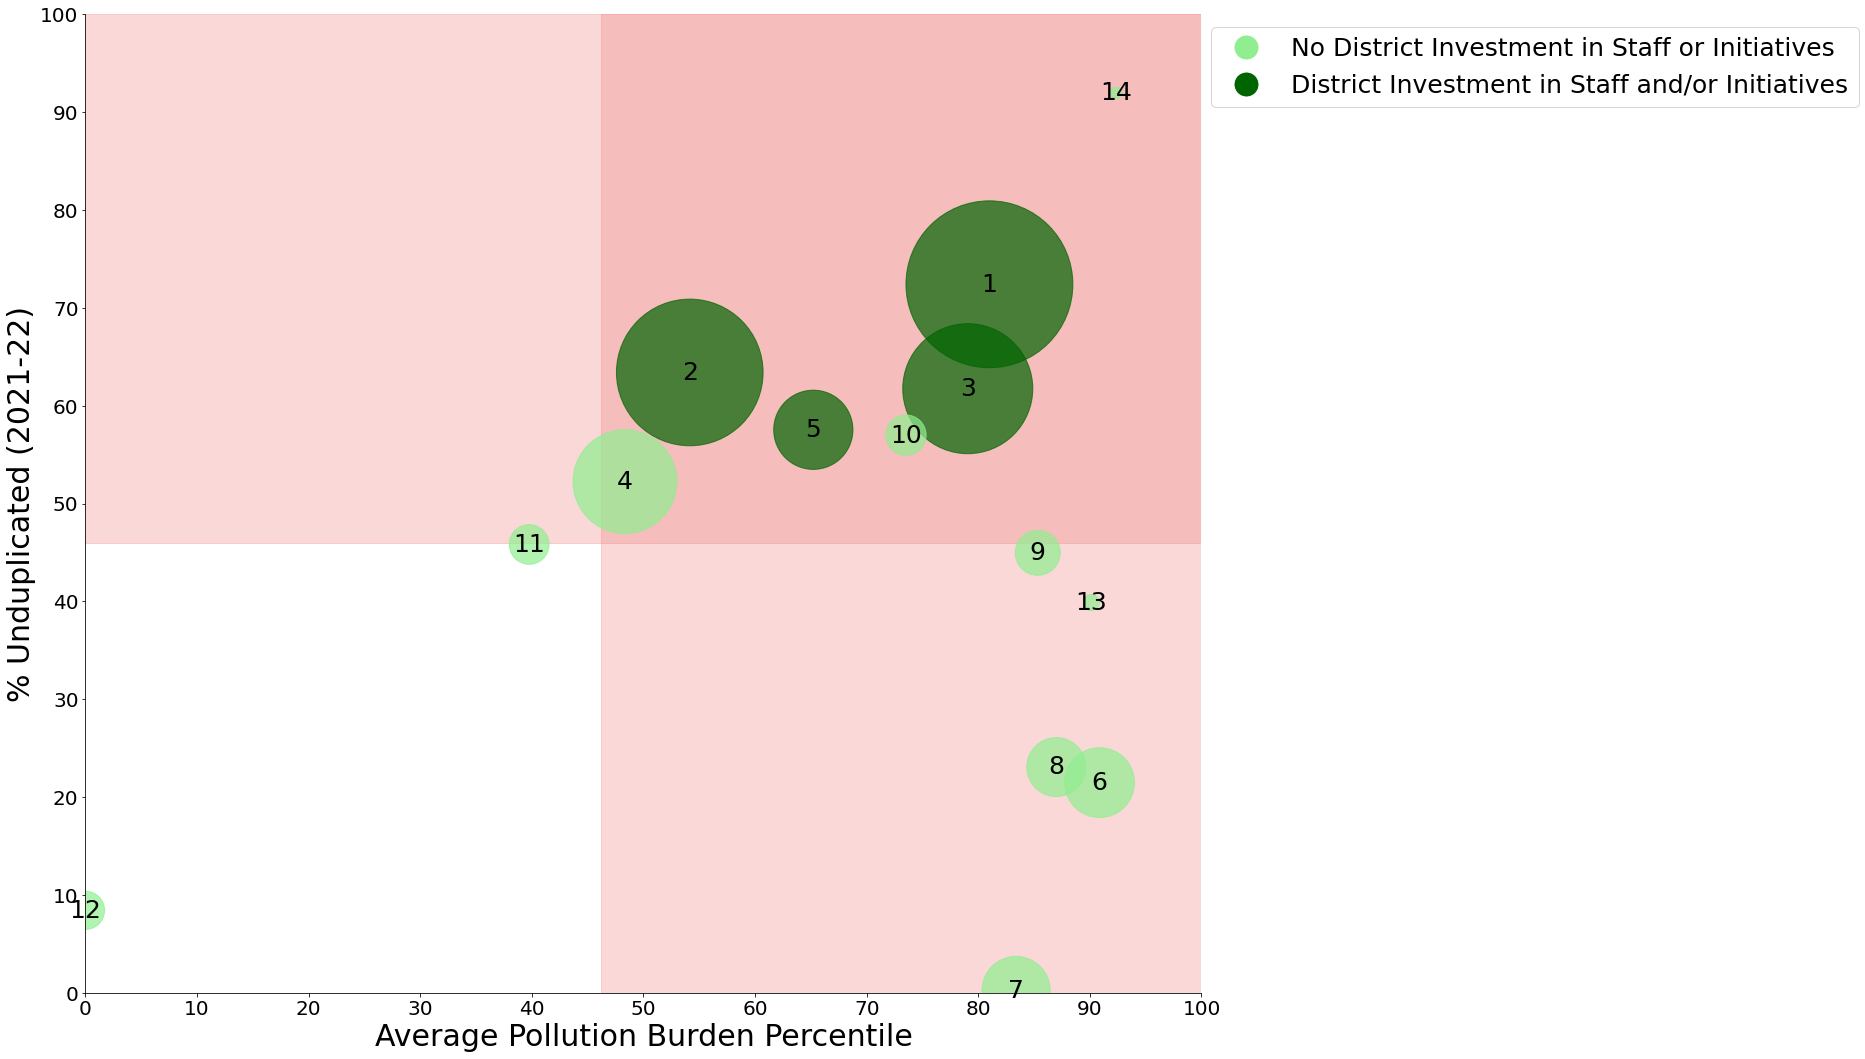

In [288]:
pollution_vs_unduplicated_graph(cleaned_san_joaquin, 'San Joaquin County')

### Orange County

In [310]:
cleaned_orange_county = county_data_cleaning(orange_county)
cleaned_orange_county

,District Type,District Name,% Unduplicated \n(2021-22),Student Enrollment \n(2021-22),Average CalEnviroScreen Percentile,District with investment
1,Elementary School District,Anaheim Elementary,87.53,15409,91.7000,0
2,High School District,Anaheim Union High,76.56,28404,76.6600,1
3,Unified School District,Brea-Olinda Unified,30.93,5866,93.1700,0
4,Elementary School District,Buena Park Elementary,80.40,4015,95.4800,0
5,Unified School District,Capistrano Unified,23.45,49974,36.5300,1
6,Elementary School District,Centralia Elementary,70.31,4077,69.2800,0
7,Elementary School District,Cypress Elementary,50.29,3414,53.9700,0
8,Elementary School District,Fountain Valley Elementary,28.59,5998,61.3500,0
9,Elementary School District,Fullerton Elementary,60.80,11681,83.4900,0
10,High School District,Fullerton Joint Union High,59.12,13431,76.4800,1


In [311]:
def pollution_vs_unduplicated_graph(cleaned_county_data, county_name):
    '''
    cleaned_county_data is a county dataset cleaned by using function county_data_cleaning(county_data)
    county_name is a string, e.g., 'San Mateo County'
    '''
    x_values = cleaned_county_data['Average CalEnviroScreen Percentile']
    y_values = cleaned_county_data['% Unduplicated \n(2021-22)']
    dot_sizes = cleaned_county_data['Student Enrollment \n(2021-22)']
    scaling_factor = 0.5
    dot_sizes_scaled = dot_sizes * scaling_factor

    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # Create the scatter plot
    plt.figure(figsize=(12, 12))
    
    # Define the boundaries of the upper-right quadrant
    x_upper_bound = max(x_values)
    y_upper_bound = max(y_values)

    # Add shaded background for the upper-right quadrant
    plt.axhspan(y_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    plt.axvspan(x_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    
    # Scatter plot with original colors
    colors = {0: 'lightgreen', 1: 'darkgreen'}
    scatter = plt.scatter(x_values, y_values, s=dot_sizes_scaled,
                          c=[colors[i] for i in cleaned_county_data['District with investment']],
                          cmap='Greens', alpha=0.7)
    

    
    # Label the dots with district numbers
    for i, (x, y) in enumerate(zip(x_values, y_values)):
        district_number = cleaned_county_data.index[i]  # Assuming index represents district numbers
        plt.text(x, y, district_number, ha='center', va='center', color='black', fontsize=16)

    # Set labels and title
    plt.xlabel('Average Cal EnviroScreen Percentile', size=15)
    plt.xticks(range(0, 101, 10))
    plt.xlim(0, 100)
    plt.ylabel('% Unduplicated (2021-22)', size=15)
    plt.yticks(range(0, 101, 10))
    plt.ylim(0, 100)
    
    # plt.title(county_name + ': Pollution Burden Percentile vs. % Unduplicated', size=20, pad=30)

    # Add custom legend
    legend_labels = ['No District Investment in Staff or Initiatives', 'District Investment in Staff and/or Initiatives']  # Custom labels for the legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=10)]
    plt.legend(legend_handles, legend_labels, 
               title_fontsize=15, bbox_to_anchor=(1.8, 0.95), loc='upper right', prop={"size": 15})

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Show the plot
    plt.savefig('Bubble Graphs Outputs/' + county_name + ' Bubble Visuals.png', bbox_inches='tight')
    plt.show()

In [314]:
import matplotlib.pyplot as plt
import numpy as np

def pollution_vs_unduplicated_graph(cleaned_county_data, county_name):
    '''
    cleaned_county_data is a county dataset cleaned by using function county_data_cleaning(county_data)
    county_name is a string, e.g., 'San Mateo County'
    '''
    x_values = cleaned_county_data['Average CalEnviroScreen Percentile']
    y_values = cleaned_county_data['% Unduplicated \n(2021-22)']
    dot_sizes = cleaned_county_data['Student Enrollment \n(2021-22)']
    scaling_factor = 0.3
    dot_sizes_scaled = dot_sizes * scaling_factor

    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # Create the scatter plot
    plt.figure(figsize=(20, 18))
    
    # Define the boundaries of the upper-right quadrant
    x_upper_bound = max(x_values)
    y_upper_bound = max(y_values)

    # Add shaded background for the upper-right quadrant
    plt.axhspan(y_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    plt.axvspan(x_upper_bound/2, 100, color='lightcoral', alpha=0.3)
    
    # Scatter plot with original colors
    colors = {0: 'lightgreen', 1: 'darkgreen'}
    
    # Add slight random jitter to the dot positions
    jitter_amount = 3.0  # Adjust as needed
    x_jitter = np.random.uniform(-jitter_amount, jitter_amount, len(x_values))
    y_jitter = np.random.uniform(-jitter_amount, jitter_amount, len(y_values))
    
    scatter = plt.scatter(x_values + x_jitter, y_values + y_jitter, s=dot_sizes_scaled,
                          c=[colors[i] for i in cleaned_county_data['District with investment']],
                          cmap='Greens', alpha=0.7)
    
    # Label the dots with district numbers
    for i, (x, y) in enumerate(zip(x_values, y_values)):
        district_number = cleaned_county_data.index[i]  # Assuming index represents district numbers
        plt.text(x + x_jitter[i], y + y_jitter[i], district_number, ha='center', va='center', color='black', fontsize=25)

    # Set labels and title
    plt.xlabel('Average Pollution Burden Percentile', size=30)
    plt.xticks(range(0, 101, 10), size=20)
    plt.xlim(0, 100)
    plt.ylabel('% Unduplicated (2021-22)', size=30)
    plt.yticks(range(0, 101, 10), size=20)
    plt.ylim(0, 100)
    
    # plt.title(county_name + ': Pollution Burden Percentile vs. % Unduplicated', size=20, pad=30)

    # Add custom legend
    legend_labels = ['No District Investment in Staff or Initiatives', 'District Investment in Staff and/or Initiatives']  # Custom labels for the legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=25),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=25)]
    plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1.6, 1), loc='upper right', prop={"size": 25})

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Show the plot
    plt.savefig('Bubble Graphs Outputs/' + county_name + ' Bubble Visuals.png', bbox_inches='tight')
    plt.show()



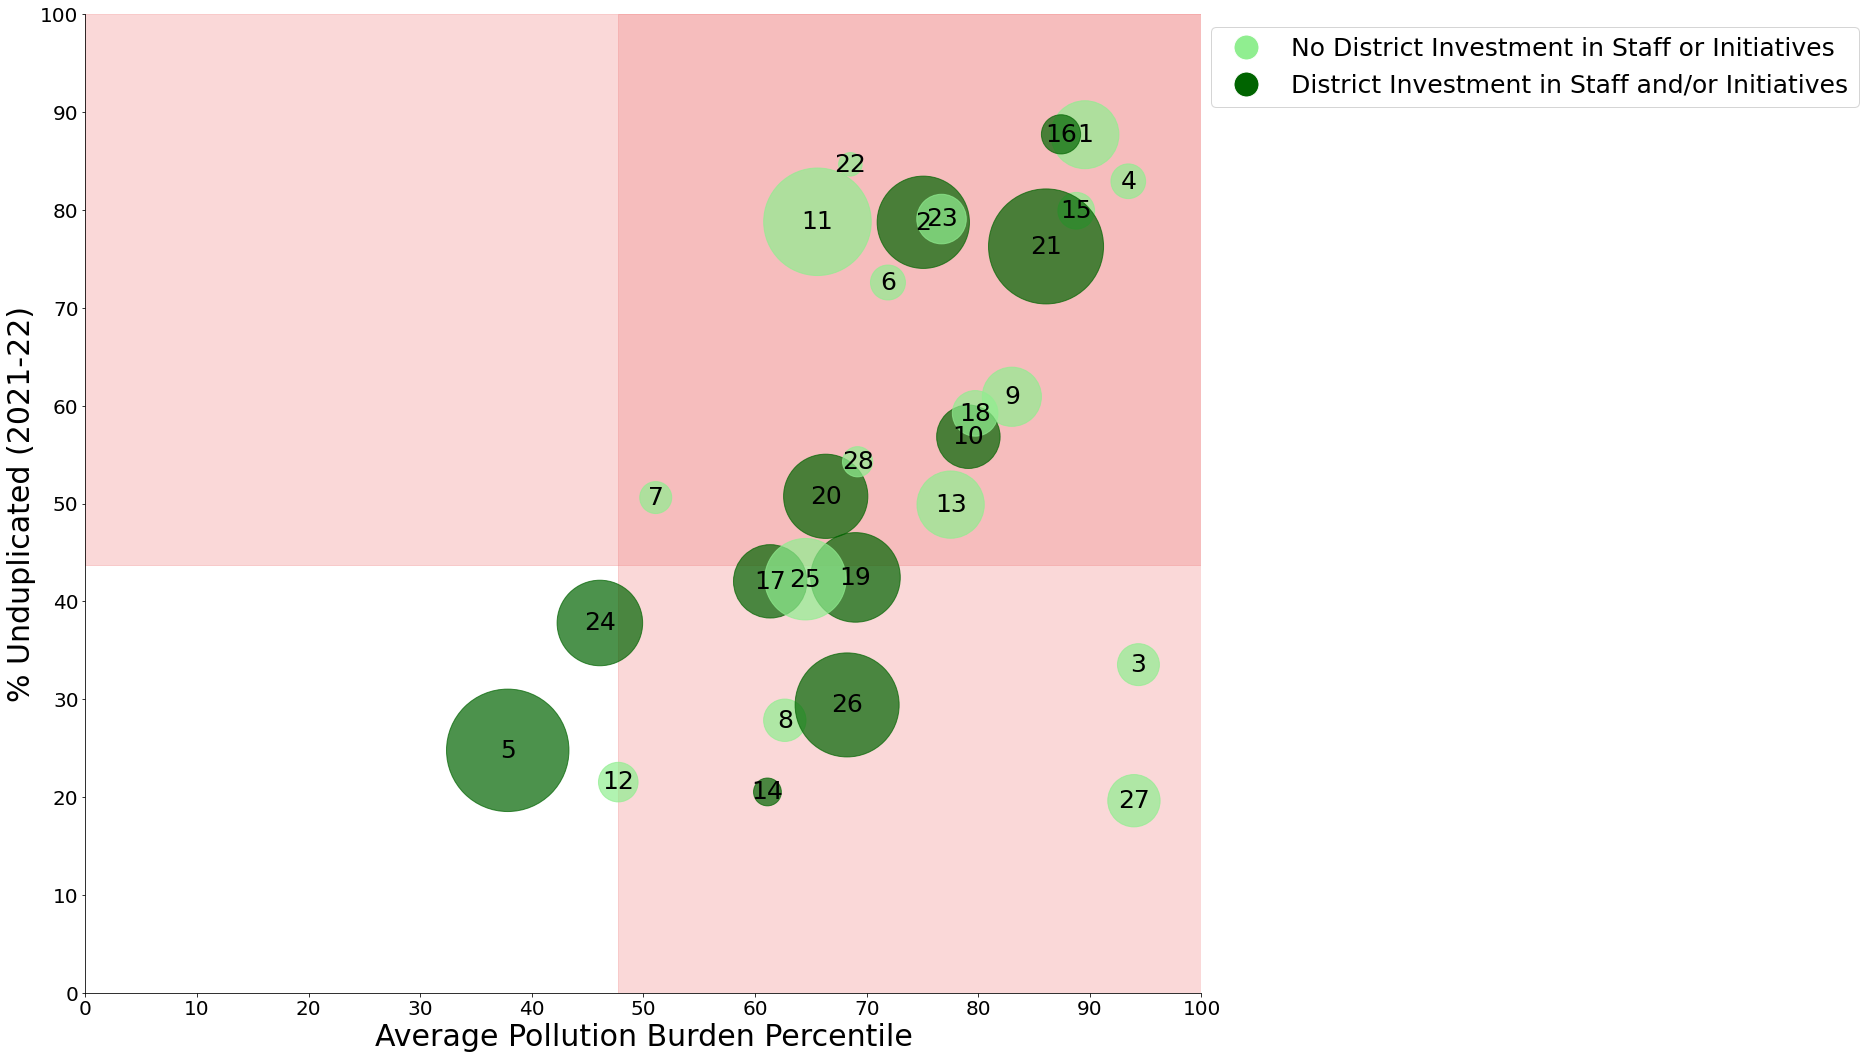

In [315]:
pollution_vs_unduplicated_graph(cleaned_orange_county, 'Orange County')